In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers.modeling_utils import (
    PreTrainedModel,
    apply_chunking_to_forward,
    find_pruneable_heads_and_indices,
    prune_linear_layer,
)
import numpy as np
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch import nn
from dataclasses import dataclass, field
from transformers.modeling_outputs import TokenClassifierOutput
from transformers import BertTokenizer,BertTokenizerFast
import torch
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
import json
from utils import *
from dataProcessing import *
import os

/home/s/sainathreddyb/.conda/envs/gpuenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


2023-01-13 17:46:35.115256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 17:46:35.379721: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-13 17:46:36.972085: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/cuda/cuda-11.5/lib64:/slurm/include:/apps/cuda/cuda-11.5/lib64:/opt/rh/devtoolset-8/root/usr/lib64:/opt/rh/devtoolset-8/root/usr/lib:/opt/rh/devtoolset-8/root/usr/lib64/dyninst:/opt/rh/devtoolset-8/root/usr

### data loading and pre processing

In [2]:
rf_dict = np.load('rf.npy',allow_pickle=True).item()

X_train = pd.read_csv('train.csv')
X_val = pd.read_csv('val.csv')
X_test = pd.read_csv('test.csv')

In [3]:
data_scaler = DataScaler(categorical_column='measurement_type', label='measurement_value',scale_by_group=False)
X_train = data_scaler.fit_transform(X_train)
X_val = data_scaler.transform(X_val)
X_test = data_scaler.transform(X_test)


In [4]:
class convert_df_fea(DataPreprocessor):
    def __init__(self, rf_dict,X_train):
        super().__init__(X_train)
        self.rf_dict = rf_dict
        
    def transform(self, X):
        X = super().transform(X)
        X['mf'] = X['SMILES'].map(self.rf_dict)      
        return X

data_preprocessor = convert_df_fea(rf_dict,X_train)
X_train = data_preprocessor.transform(X_train)
X_val = data_preprocessor.transform(X_val)
X_test = data_preprocessor.transform(X_test)

### torch data set and data loader createion

In [5]:
class dataset(Dataset):
  def __init__(self, dataframe, max_len,is_train=False):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1",add_special_tokens=True,)
        self.max_len = max_len
        self.is_train = is_train       

  def __getitem__(self, index):
        # step 1: get the sentence and word labels 

        sample=self.data.iloc[index]
        
        text=sample['SMILES']
        kinase_cat= torch.as_tensor(sample['Kinase_name'])
        meas_cat =  torch.as_tensor(sample['measurement_type'])
        mf = torch.as_tensor(sample['mf'])
    
        labels = sample['measurement_value']
        
        encoding = self. tokenizer(text, is_split_into_words=False,
                              return_offsets_mapping=True, 
                              padding='max_length', 
                              truncation=True, 
                              max_length=self.max_len)
        

        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(labels)
        item['extra_fea']= torch.cat([kinase_cat, meas_cat, mf], dim=-1)
        
        if self.is_train:
            return item
        return item, index

  def __len__(self):
        return self.len

MAX_LEN = 100
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 100
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10

training_set = dataset(X_train, MAX_LEN, is_train=True)
testing_set = dataset(X_test  , MAX_LEN)
validation_set  = dataset(X_val, MAX_LEN)

In [6]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **test_params)
testing_loader = DataLoader(testing_set, **test_params)

### Roberta model

In [7]:
class RobertaRegression(nn.Module):

    def __init__(self,extra_features,dropout,training=False):
        super().__init__()
        
        self.training = training
        self.num_labels = 1
        self.extra_features = extra_features
        self.bert = AutoModelForMaskedLM.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
        for param in self.bert.parameters():
            param.requires_grad = False

        self.emb_dim = 256
        
        if extra_features:
          self.hidden_layer = 767+4690
        else:
          self.hidden_layer = 767
        
        self.drop_ratio = dropout
        
        module_list = [
            torch.nn.Linear(self.hidden_layer, self.emb_dim),
            torch.nn.BatchNorm1d(self.emb_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(p = self.drop_ratio),
        ]

        for i in range(1):
            module_list += [torch.nn.Linear(self.emb_dim, self.emb_dim),
            torch.nn.BatchNorm1d(self.emb_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(p = self.drop_ratio)]
        
        # relu is applied in the last layer to ensure positivity
        module_list += [torch.nn.Linear(self.emb_dim, 1)]
        
        self.mlp = torch.nn.Sequential(
            *module_list
        )
    

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        extra_fea=None
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict 
        )

        sequence_output = torch.max(outputs[0],dim=1)[0]
        
        if self.extra_features:
            sequence_output = torch.cat((sequence_output,extra_fea),dim=-1) #180*768
            
        output = self.mlp(sequence_output)
        
        if self.training:
            return output.squeeze() 
        else:
            # At inference time, relu is applied to output to ensure positivity
            return torch.clamp(output, min=0, max=1).squeeze()
        



model = RobertaRegression(extra_features=True,dropout=0.2,training=True)
loss_fn = nn.L1Loss()

model.to(device)

RobertaRegression(
  (bert): RobertaForMaskedLM(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(767, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_features=76

In [8]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
#loading already trained model comment if you want to train from scratch
model.load_state_dict(torch.load('model.pt', map_location='cpu'))

<All keys matched successfully>

In [44]:
def eval(model, loader):
    model.eval()
     # compute the validation loss and MAE
    val_loss = 0.0
    val_mae = 0.0
    num_val_samples = 0
    
    for idx, batch in enumerate(validation_loader):
        batch = batch[0]
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        extra_fea = batch['extra_fea'].to(device, dtype = torch.float)
        labels = batch['labels'].to(device, dtype = torch.float)
        output = model(input_ids=ids, attention_mask=mask, extra_fea=extra_fea)
        
        loss = loss_fn(output, labels)
    
        
        # update the running validation loss
        val_loss += loss.item() * labels.size(0)
        # update the running validation MAE
        val_mae += torch.abs(output - labels).mean().item() * labels.size(0)
        num_val_samples += labels.size(0)
        
        if idx==2:
            break

    # compute the average validation loss and MAE
    val_loss /= num_val_samples
    val_mae /= num_val_samples
    
    # print the training and validation loss and MAE
    print(f'Epoch {epoch+1}: val loss = {val_loss:.4f}, val MAE = {val_mae:.4f}')
    return val_mae

def train(model, loader, optimizer):
    model.train()
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.float)
        extra_fea = batch['extra_fea'].to(device, dtype = torch.float)
        
        tr_logits = model(input_ids=ids, attention_mask=mask, extra_fea=extra_fea)
        
        loss = loss_fn(tr_logits, labels)
        
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            break

    epoch_loss = tr_loss / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    return epoch_loss

In [9]:
logger = get_logger()

2023-01-13 17:46:57,099 - utils - INFO - This is a test log message


In [51]:
best_valid_mae = 9999
checkpoint_dir = 'chepoint3'
reg_criterion = torch.nn.L1Loss()
epochs = 500
for epoch in range(epochs):
    logger.info("=====Epoch {}".format(epoch))
    print('Training...')
    train_loss = train(model, training_loader, optimizer)

    print('Evaluating...')
    valid_mae = eval(model, validation_loader)

    logger.info('#summary: %.4f %.4f'.format(train_loss, valid_mae))

    if valid_mae < best_valid_mae:
        best_valid_mae = valid_mae
        if checkpoint_dir != '':
            print('Saving checkpoint...')
            checkpoint = {'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'best_val_mae': best_valid_mae}
            torch.save(checkpoint, os.path.join(checkpoint_dir, 'checkpoint.pt'))
    

2023-01-13 16:42:54,675 - utils - INFO - =====Epoch 0
2023-01-13 16:42:54,675 - utils - INFO - =====Epoch 0
2023-01-13 16:42:54,675 - utils - INFO - =====Epoch 0
2023-01-13 16:42:54,675 - utils - INFO - =====Epoch 0
2023-01-13 16:42:54,675 - utils - INFO - =====Epoch 0


Training...
Training loss per 100 training steps: 0.18325886130332947
Training loss epoch: 0.18325886130332947
Evaluating...


2023-01-13 16:42:57,171 - utils - INFO - #summary: %.4f %.4f
2023-01-13 16:42:57,171 - utils - INFO - #summary: %.4f %.4f
2023-01-13 16:42:57,171 - utils - INFO - #summary: %.4f %.4f
2023-01-13 16:42:57,171 - utils - INFO - #summary: %.4f %.4f
2023-01-13 16:42:57,171 - utils - INFO - #summary: %.4f %.4f


Epoch 1: val loss = 0.0987, val MAE = 0.0987
Saving checkpoint...


2023-01-13 16:42:58,680 - utils - INFO - =====Epoch 1
2023-01-13 16:42:58,680 - utils - INFO - =====Epoch 1
2023-01-13 16:42:58,680 - utils - INFO - =====Epoch 1
2023-01-13 16:42:58,680 - utils - INFO - =====Epoch 1
2023-01-13 16:42:58,680 - utils - INFO - =====Epoch 1


Training...
Training loss per 100 training steps: 0.15279585123062134
Training loss epoch: 0.15279585123062134
Evaluating...


2023-01-13 16:43:01,065 - utils - INFO - #summary: %.4f %.4f
2023-01-13 16:43:01,065 - utils - INFO - #summary: %.4f %.4f
2023-01-13 16:43:01,065 - utils - INFO - #summary: %.4f %.4f
2023-01-13 16:43:01,065 - utils - INFO - #summary: %.4f %.4f
2023-01-13 16:43:01,065 - utils - INFO - #summary: %.4f %.4f


Epoch 2: val loss = 0.0915, val MAE = 0.0915
Saving checkpoint...


2023-01-13 16:43:02,253 - utils - INFO - =====Epoch 2
2023-01-13 16:43:02,253 - utils - INFO - =====Epoch 2
2023-01-13 16:43:02,253 - utils - INFO - =====Epoch 2
2023-01-13 16:43:02,253 - utils - INFO - =====Epoch 2
2023-01-13 16:43:02,253 - utils - INFO - =====Epoch 2


Training...
Training loss per 100 training steps: 0.14826585352420807
Training loss epoch: 0.14826585352420807
Evaluating...


2023-01-13 16:43:04,665 - utils - INFO - #summary: %.4f %.4f
2023-01-13 16:43:04,665 - utils - INFO - #summary: %.4f %.4f
2023-01-13 16:43:04,665 - utils - INFO - #summary: %.4f %.4f
2023-01-13 16:43:04,665 - utils - INFO - #summary: %.4f %.4f
2023-01-13 16:43:04,665 - utils - INFO - #summary: %.4f %.4f


Epoch 3: val loss = 0.0778, val MAE = 0.0778
Saving checkpoint...


KeyboardInterrupt: 

In [10]:
def get_preds(loader,df):
    
    batch_idx=[]
    outputs=[]
    model.eval()
    for idx, batch in enumerate(loader):
        batch_idx.extend([i.item() for i in batch[1]])
        batch = batch[0]
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        extra_fea = batch['extra_fea'].to(device, dtype = torch.float)
        labels = batch['labels'].to(device, dtype = torch.float)
        output = model(input_ids=ids, attention_mask=mask, extra_fea=extra_fea)

        outputs.extend([i.item() for i in output])

        loss = loss_fn(output, labels)


        # update the running validation loss
        val_loss = loss.item() * labels.size(0)
        # update the running validation MAE
        val_mae = torch.abs(output - labels).mean().item() * labels.size(0)

        print(torch.abs(output - labels).mean().item(),labels.size(0))

        # print(output,labels)
    testit = df.iloc[batch_idx].copy()
    testit['preds'] = outputs
    testit['abs'] =abs( testit.measurement_value - testit.preds)
    
    return testit

In [11]:
X_test=get_preds(testing_loader,X_test)

0.065398208796978 100
0.06528279930353165 100
0.06673705577850342 100
0.059619151055812836 100
0.062392596155405045 100
0.06193697825074196 100
0.0628121867775917 100
0.061950769275426865 100
0.05549531802535057 100
0.06557631492614746 100
0.06233209744095802 78


In [12]:
X_val=get_preds(validation_loader,X_val)

0.06579607725143433 100
0.07723863422870636 100
0.07430273294448853 100
0.0580110028386116 100
0.06893663108348846 100
0.06216086819767952 100
0.05350809916853905 100
0.07003188133239746 100
0.06705641746520996 100
0.07926966995000839 100
0.0661376491189003 77


### test val mae

In [13]:
np.mean(X_test['abs']),np.mean(X_val['abs'])

(0.06269206264250356, 0.06752442280051395)

In [14]:
testit=pd.concat((X_test,X_val))
testit = data_scaler.inverse_transform(testit,'preds')
testit = data_scaler.inverse_transform(testit,'measurement_value')
testit = data_preprocessor.reverse_transform(testit)

In [16]:
get_accuracy_mae(testit)

unscaled mae: 0.3912938003607804
Accuracy of pKi :  0.7448979591836735
Accuracy of pIC50 :  0.8116169544740973


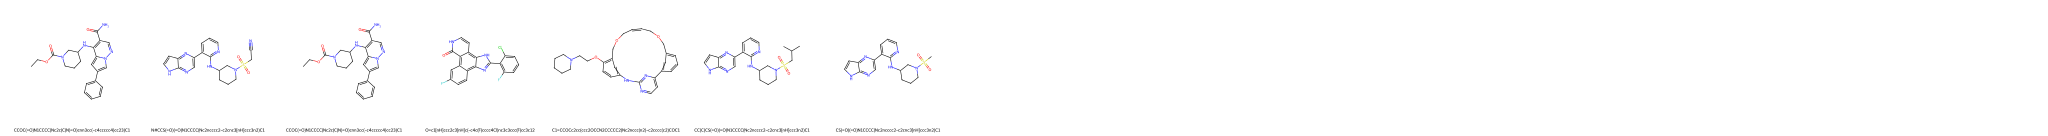

In [17]:


import matplotlib.pyplot as plt
from rdkit.Chem import Draw
from rdkit import Chem
# generate a list of "smile" molecules
smiles = testit[testit['abs']>2].SMILES.values
molecules = [Chem.MolFromSmiles(smile) for smile in smiles]

Draw.MolsToGridImage(molecules, molsPerRow=15, useSVG=True,subImgSize=(500, 500), legends=list(smiles))

In [24]:
np.mean(testit[testit.measurement_type == 'pKi']['abs']),np.mean(testit[testit.measurement_type == 'pIC50']['abs']),

(0.37529836711507697, 0.3957190772125242)

In [27]:
testit[testit['abs']>1.87]

,SMILES,measurement_type,measurement_value,Kinase_name,mf,preds,abs
131,CCOC(=O)N1CCCC(Nc2c(C(N)=O)cnn3cc(-c4ccccc4)cc...,pIC50,6.55,JAK1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.732034,2.182034
969,CC=CS(=O)(=O)Nc1cccc(-c2ncnc3[nH]cc(C(=O)OCC)c...,pIC50,8.09,JAK1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...",10.056711,1.966711
717,Cc1cccc(C)c1-c1cc2c(NC3C4CC5CC3CC(O)(C5)C4)c(C...,pIC50,6.28,JAK3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",8.172404,1.892404
427,CS(=O)(=O)N1CCCC(Nc2nc(N)ncc2-c2cnc3[nH]ccc3n2)C1,pIC50,7.28,JAK1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",9.196299,1.916299
322,CN(c1ccc(S(N)(=O)=O)cn1)C1CCN(c2ncnc3[nH]ccc23)C1,pIC50,7.39,JAK2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.383981,1.993981
12,N#CCS(=O)(=O)N1CCCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1,pIC50,7.82,JAK1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",10.382913,2.562913
928,CCOC(=O)N1CCCC(Nc2c(C(N)=O)cnn3cc(-c4ccccc4)cc...,pIC50,6.55,JAK3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.737966,2.187966
90,O=c1[nH]ccc2c3[nH]c(-c4c(F)cccc4Cl)nc3c3ccc(F)...,pIC50,9.22,JAK3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",7.194283,2.025717
223,C1=CCOCc2cc(ccc2OCCN2CCCCC2)Nc2nccc(n2)-c2cccc...,pIC50,6.12,JAK1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",8.226169,2.106169
252,CC(C)CS(=O)(=O)N1CCCC(Nc2ncccc2-c2cnc3[nH]ccc3...,pIC50,6.99,JAK1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",10.771221,3.781221
